# Problem Background: The Great Migration

In our ongoing efforts to ensure the safety of the migration to Earth Junior, we have developed a linear regression model that produces a human-zombie score ranging from 0 to 100. This score is designed to assess the likelihood of individuals being human or zombie based on various features collected during screening.

To enhance our security measures, the spaceship station has deployed a specialized automated barrier system that utilizes the human-zombie scores to classify individuals into three distinct categories:

- **Class 0: Score Range 0-33**: **Most Likely Human**  
  Individuals in this range will be directed straight to the spaceship for immediate boarding.

- **Class 1: Score Range 33-66**: **Need Further Tests**  
  Those with scores in this range will be redirected to a testing facility for additional examinations to confirm their identity. They will be quarantined for a two-week observational period to ensure they do not pose a risk.

- **Class 3: Score Range 66-100**: **Most Likely Zombies**  
  Those scoring in this highest range will be denied entry to the spaceship, as they are deemed a significant threat to the safety of the remaining human population.

This classification system aims to maximize the chances of a successful migration while ensuring that the risk of zombie infiltration is minimized.


# Logistic Regression 


<center>
  <img src = "https://miro.medium.com/v2/resize:fit:1100/format:webp/1*RElrybCZ4WPsUfRwDl7fqA.png">
</center>

One vs All (OvA) is a common technique to extend binary classifiers, like logistic regression, to handle multiclass classification tasks. For each class in the dataset, a logistic regression model is trained to distinguish that class from all other classes. For instance, for a `m` class classification, we will have `m` logistic regression classifiers in our pipeline. When making a prediction, each model outputs a probability that the instance belongs to its target class. The class with the highest probability across all models is chosen as the final prediction.



## Import Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
# from sklearn import stdscaler

#### Dataset



In [17]:
df = pd.read_csv('human_zombie_dataset_v5.csv')

x = df.drop('Human-Zombie Score', axis=1)     

## Preprocessing  


1. **Transform Labels**:  
   Convert the labels from continuous scores to categorical labels based on the class descriptions provided earlier.  

2. **Perform Train-Test Split**:  
   Split the dataset into training and testing sets (8:2), and then check the sizes of both.  
   This step ensures that you have the right distribution of data for training and evaluation. 

3. **Normalize Data**:  
   Utilize the `Scaler` class to normalise data


In [18]:
divisions = [0, 33, 66, 100]  # The bin edges for each class
labels = [0, 1, 2]  # Class labels: 0 (Human), 1 (Need Further Tests), 2 (Zombie)

# Create categorical labels using pd.cut
df['class_label'] = pd.cut(df['Human-Zombie Score'], bins=divisions, labels=labels, include_lowest=True)

y = df['class_label']


In [19]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (800, 6)
Test data shape: (200, 6)
Training labels shape: (800,)
Test labels shape: (200,)


In [20]:
# Normalize
class Scaler:
    def __init__(self):
        self.means = None
        self.stds = None
    
    def fit(self, x):
        self.means = x.mean(axis=0)
        self.stds = x.std(axis=0)
    
    def transform(self, x):
        centered_data = x - self.means
        scaled_data = centered_data / self.stds
        return scaled_data

# Instantiate and apply the scaler
scaler = Scaler()

# Normalize the training and test data
scaler.fit(x_train)  
x_train_normalised = scaler.transform(x_train) 
x_test_normalised = scaler.transform(x_test)   
y_train = np.array(y_train).flatten()
y_test = np.array(y_test).flatten()

## Part A: Implementation from Scratch 

We will create a class, and implement the functionality described below to create a fully fledged **Regularized Logistic Regression model.**

* `sigmoid(x)`: This is the non-linear "activation" function that differentiates Logistic from plain-old Linear Regression. Refer to the formula from the slides.

* `cross_entropy_loss(y_true, y_pred)`: This is the loss function that will help you calculate the gradients for updating your model. 

* `fit(x_train, y_train)`: This will be where we implement the Gradient Descent algorithm

* `predict(x_test)`: predict whether the label is 0 or 1 for test reviews using learned logistic regression (use the decision threshold of 0.5) 

* `evaluate(y_true, y_pred)` function that calculates classification accuracy, F1 Score and confusion matrix. 

In [21]:


class Logistic_Regression():
    def __init__(self, learning_rate, epochs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.features = None
        self.weights = None
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def cross_entropy_loss(self, y_label, y_predict):
        epsilon = 1e-15
        y_predict = np.clip(y_predict, epsilon, 1 - epsilon)
        positive_loss = y_label * np.log(y_predict)
        negative_loss = (1 - y_label) * np.log(1 - y_predict)
        log_loss = positive_loss + negative_loss
        result = -np.mean(log_loss)
        return result

    
    def fit(self, x, y):       
        num_samples, num_features = x.shape
        self.features = num_features + 1
        self.weights = np.ones(self.features, dtype=float)
        self.loss_history = []

        x_bias = np.concatenate((x.to_numpy(), np.ones((num_samples, 1))), axis=1)

        for epoch in range(self.epochs):
            predictions = self.calculate_predictions(x_bias)
            gradients = np.zeros(self.features, dtype=float)

            for feature_index in range(self.features):
                errors = (predictions - y) * x_bias[:, feature_index]
                gradients[feature_index] = np.sum(errors)
            
            self.weights -= self.learning_rate * gradients
            error = self.cross_entropy_loss(y, predictions)
            self.loss_history.append(error)

        return self.loss_history

    def calculate_predictions(self, x):
        thetas_transpose = self.weights.reshape(-1, 1)  
        dot_product = np.dot(x, thetas_transpose)  
        dot_product_flattened = dot_product.flatten()  
        sigmoid_values = []
        for value in dot_product_flattened:
            sigmoid_value = self.sigmoid(value)
            sigmoid_values.append(sigmoid_value)  
        return np.array(sigmoid_values)  

    def predict(self, x):
        bias_column = np.ones((x.shape[0], 1))
        x_with_bias = np.concatenate((x, bias_column), axis=1)
        dot_product = np.dot(x_with_bias, self.weights)
        y_predicted = self.sigmoid(dot_product)
        predicted_labels = (y_predicted >= 0.5).astype(int)
        return predicted_labels, y_predicted


    def evaluate(self, y_label, y_predicted):
        accuracy = accuracy_score(y_label, y_predicted)
        f1 = f1_score(y_label, y_predicted)
        conf_matrix = confusion_matrix(y_label, y_predicted)
        return(accuracy, f1, conf_matrix)


## Implement One vs All Classification  

We will build four classifiers, one for each class, and perform the following steps for each:

1. Create a plot with the number of iterations/epochs on the x-axis and training/validation loss on the y-axis for the evaluation dataset that we separated previously.

2. Tune the hyperparameters, i.e., learning rate and number of epochs, to minimize the validation loss.




Evaluation Metrics for Class 0
------------------------------
Class 0 - Final Loss: 0.1060
Accuracy       : 96.00%
F1 Score       : 0.9365
Confusion Matrix:
[[133   6]
 [  2  59]]
------------------------------

Evaluation Metrics for Class 1
------------------------------
Class 1 - Final Loss: 0.6156
Accuracy       : 62.00%
F1 Score       : 0.0000
Confusion Matrix:
[[124   0]
 [ 76   0]]
------------------------------

Evaluation Metrics for Class 2
------------------------------
Class 2 - Final Loss: 0.1067
Accuracy       : 95.00%
F1 Score       : 0.9219
Confusion Matrix:
[[131   6]
 [  4  59]]
------------------------------


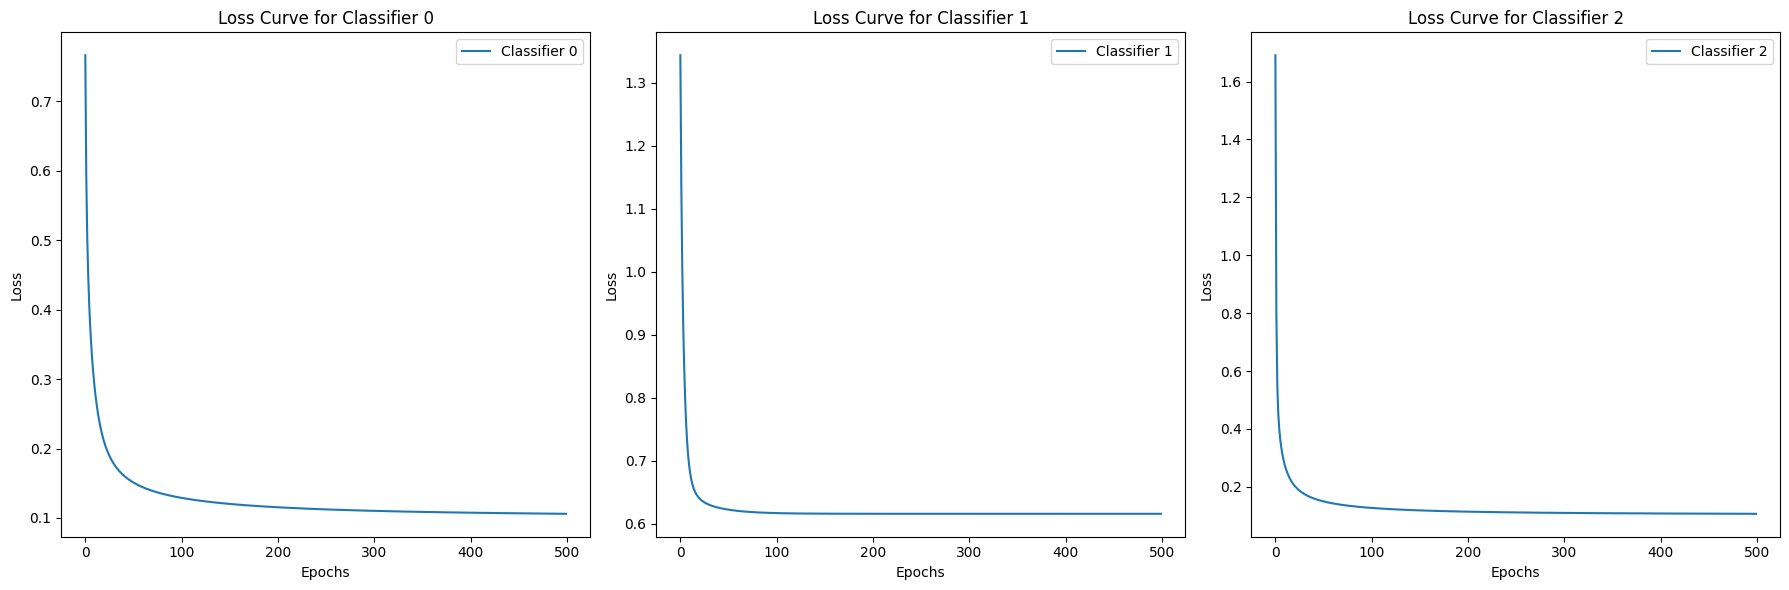

In [22]:


epoch = 500
classifiers = {}
losses = {} 
metrics = {"accuracy": [], "f1_score": [], "confusion_matrix": []}

def plot_loss_curve(epochs, loss_values, ax, label_index):
    ax.plot(range(epochs), loss_values, label=f'Classifier {label_index}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Loss Curve for Classifier {label_index}')
    ax.legend()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i in range(3):
    binary_labels = (y_train == i).astype(int)  
    classifiers[i] = Logistic_Regression(learning_rate=0.001, epochs=epoch)  

    epoch_losses = classifiers[i].fit(x_train_normalised, binary_labels)  
    losses[i] = epoch_losses  

    predictions, _ = classifiers[i].predict(x_test_normalised)
    test_label = (y_test == i).astype(int)
    evaluation_results = classifiers[i].evaluate(test_label, predictions)

    metrics["accuracy"].append(evaluation_results[0])
    metrics["f1_score"].append(evaluation_results[1])
    metrics["confusion_matrix"].append(evaluation_results[2])

    plot_loss_curve(epoch, losses[i], axes[i], i)

    
    print(f"\nEvaluation Metrics for Class {i}")
    print("-" * 30)
    print(f"Class {i} - Final Loss: {losses[i][-1]:.4f}")
    print(f"Accuracy       : {metrics['accuracy'][i]:.2%}")
    print(f"F1 Score       : {metrics['f1_score'][i]:.4f}")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'][i])
    print("-" * 30)
    
    

plt.tight_layout()
plt.show()




## Evaluate 

It's time to run the logistic regression model on the test dataset!

- Reporting the accuracy, F1 score and confusion matrix for each binary classifier 
- Performing multiclass evaluation and reporting macro F1, accuracy and confusion matrix 


In [23]:
# Evaluate each binary classifier

results = {
    'Class': [],
    'Probs':[],
    'Accuracy': [],
    'F1 Score': [],
    'Confusion Matrix': []
}

for i in range(3):
    binary_labels = (y_test == i).astype(int)  
    predicted_class, probability = classifiers[i].predict(x_test_normalised)  

    evaluation_results = classifiers[i].evaluate(binary_labels, predicted_class)
    accuracy = evaluation_results[0]
    f1 = evaluation_results[1]
    cm = evaluation_results[2]

    results['Class'].append(i)
    results['Probs'].append(probability)
    results['Accuracy'].append(accuracy)
    results['F1 Score'].append(f1)
    results['Confusion Matrix'].append(cm)

results_df = pd.DataFrame(results)

In [24]:
results_df.drop('Probs',axis=1)

,Class,Accuracy,F1 Score,Confusion Matrix
0,0,0.96,0.936508,"[[133, 6], [2, 59]]"
1,1,0.62,0.000000,"[[124, 0], [76, 0]]"
2,2,0.95,0.921875,"[[131, 6], [4, 59]]"


In [25]:
# Multi class evaluations.
# Combine the probabilites of the classifiers calculated above and assign label of the classifier having the highest probability
class_labels = ['Class 0: Most Likely Human', 
                'Class 1: Further Testing', 
                'Class 2: Most Likely Zombie']

r = results['Probs']
probabilities = np.array(r).T  
predictions = np.argmax(probabilities, axis=1).tolist()

Accuracy: 0.895
F1 Score: 0.8957013158272421


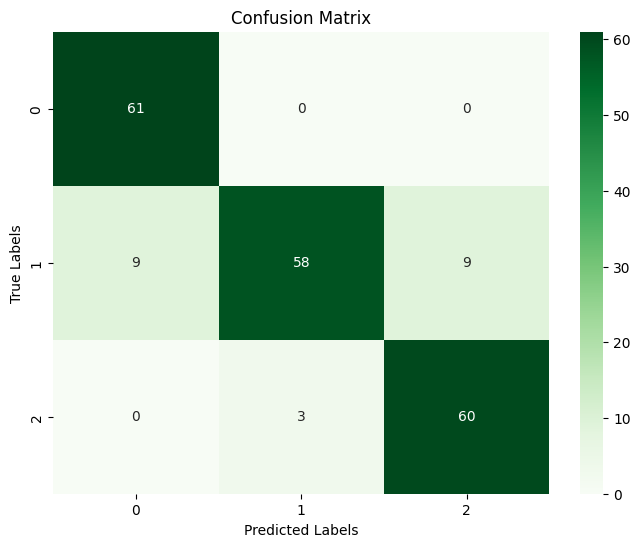

In [26]:
# Calculate the macro f1, accuracy and confusion matrix for multiclass classification

accuracy = np.mean(y_test == np.array(predictions))
print('Accuracy:', accuracy)

f1_macro = f1_score(y_test, np.array(predictions), average='macro')
print("F1 Score:", f1_macro)

conf_matrix = confusion_matrix(y_test, np.array(predictions))

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Part B: Using Scikit-learn  

In this part, we use scikit-learn’s [Logistic Regression] implementation to train and test the logistic regression on the provided dataset.

Accuracy: 91.00%
F1 Score: 0.91


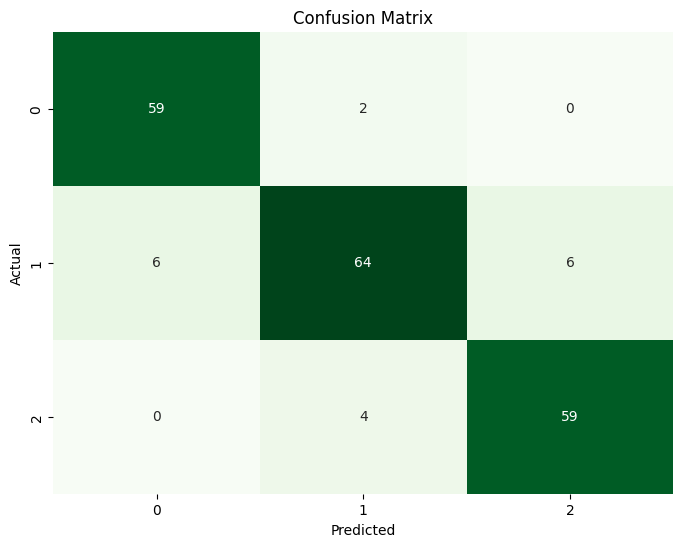

In [27]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42, max_iter=1000)  # Adjust max_iter if needed

log_reg.fit(x_train_normalised, y_train)

y_pred = log_reg.predict(x_test_normalised)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Using weighted average to handle class imbalance

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Part C: Am I a Zombie? 
Using my multiclass classifier to predict whether I am a zombie.

In [28]:

height = 172              # Height in cm
weight = 80              # Weight in kg
screen_time = 6         # Screen time in hours per day
junk_food_days = 1      # Junk food consumption in days per week
physical_activity = 3    # Physical activity in hours per week
task_completion = 7     # Task completion on a scale (example range: 1-10)

In [29]:
test_point = np.array([height, weight, screen_time, junk_food_days, physical_activity, task_completion])
test_point = scaler.transform(test_point)  # transform using your standard scaler instance

In [30]:

labels = {0: "Human", 1: "Needs Further Testing", 2: "Zombie"}
probs=[] 
for i in range(3):  
    y_pred_class, prob = classifiers[i].predict(np.array(test_point).reshape(1, -1))    
    probs.append(prob)
combined_probs = np.column_stack([p for p in probs])
multi_class_pred = np.argmax(combined_probs, axis=1)
print("Prediction:", labels[multi_class_pred[0]])

Prediction: Human
